In [3]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 31)

## Step 2

Let us take the example of the oil ETF time series that we collected back in GWP1 to illustrate bull, bear and stagnant regimes.

In [7]:
#redownloading the Oil ETF time series
oil_etf = yf.download('USO', start=start, end=end)['Close']

C:\Users\susha\AppData\Local\Temp\ipykernel_126780\162597237.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_etf = yf.download('USO', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed


let us now plot this time series

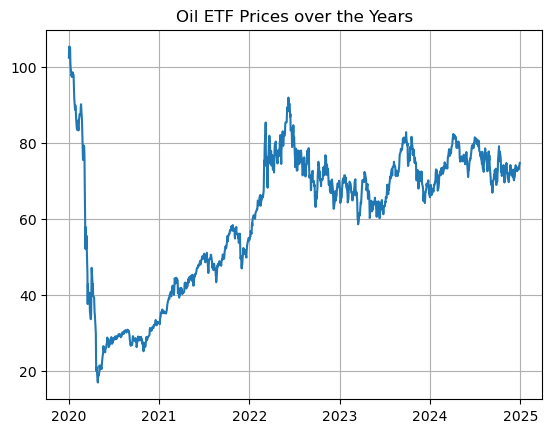

In [12]:
plt.plot(oil_etf)
plt.title("Oil ETF Prices over the Years")
plt.grid()

Now, let us zoom in some time periods of this time series to illustrate different regimes.

First, the bull regime is shown. The bull regimes is characterised by a continuous upward trend in prices and positive returns.

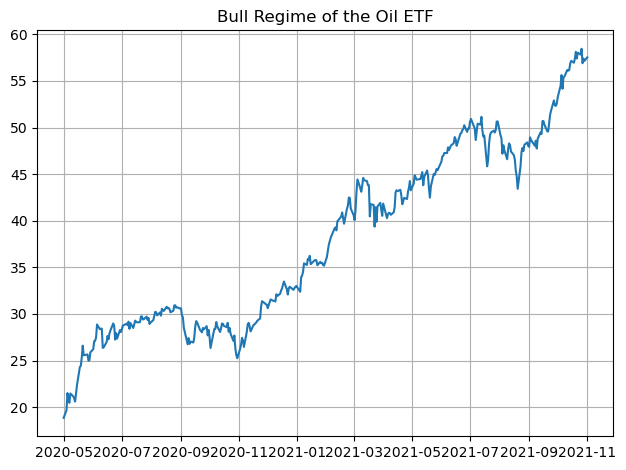

In [35]:
plt.plot(oil_etf['2020-05-01':'2021-11-01']) #1st May 2020 to 1st November 2021
plt.title("Bull Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Now, let us visualize a stagnant regime.

A stagnant regime is characterised by a sideways market and the prices usually moves within a range. There is no clear upward or downward trend in prices that sustains.

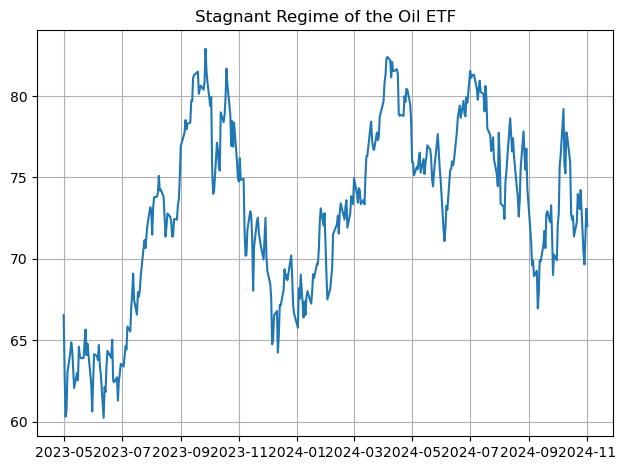

In [37]:
plt.plot(oil_etf['2023-05-01':'2024-11-01']) #1st May 2023 to 1st November 2024
plt.title("Stagnant Regime of the Oil ETF")
plt.grid()
plt.tight_layout()

Let us now visualize a bear regime.

A bear regime is characterized by a sustained decline in prices and negative returns.

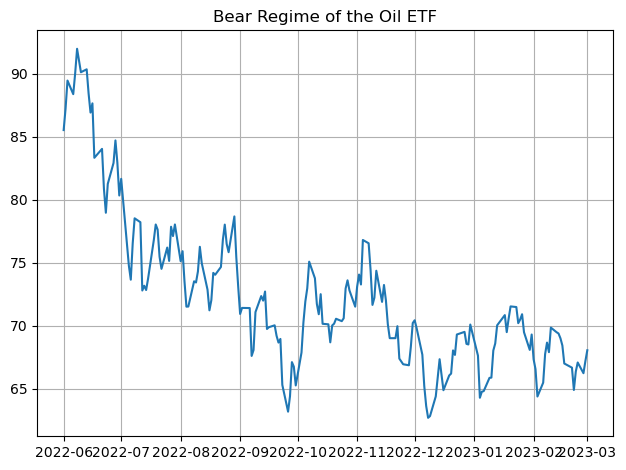

In [69]:
plt.plot(oil_etf['2022-06-01':'2023-03-01']) #1st June 2022 to 1st March 2023
plt.title("Bear Regime of the Oil ETF")
plt.grid()
plt.tight_layout()
plt.show()

Let us further illustrate these three regimes using examples of stocks from the Indian stock market.

In [83]:
itc = yf.download('ITC.NS', start=start, end=end)['Close']
vbl = yf.download('VBL.NS', start=datetime.datetime(2025, 1, 1), end=datetime.datetime(2025, 4, 1))['Close']

C:\Users\susha\AppData\Local\Temp\ipykernel_126780\3066732524.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  itc = yf.download('ITC.NS', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\susha\AppData\Local\Temp\ipykernel_126780\3066732524.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vbl = yf.download('VBL.NS', start=datetime.datetime(2025, 1, 1), end=datetime.datetime(2025, 4, 1))['Close']
[*********************100%***********************]  1 of 1 completed


First, let us see the time series for ITC

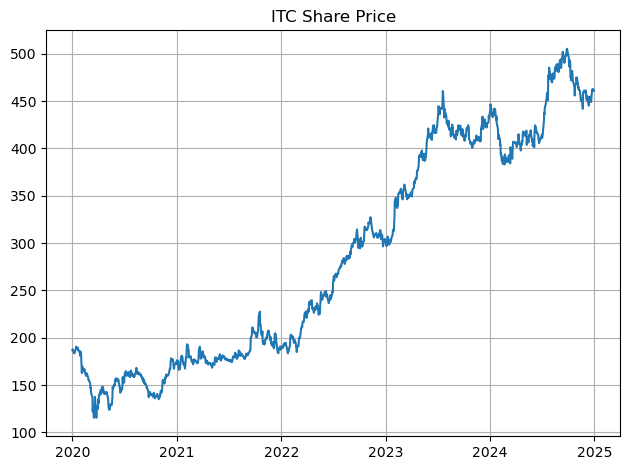

In [86]:
plt.plot(itc)
plt.title("ITC Share Price")
plt.grid()
plt.tight_layout()
plt.show()

Here, we can zoom in on different time periods to see bull and stagnant regimes

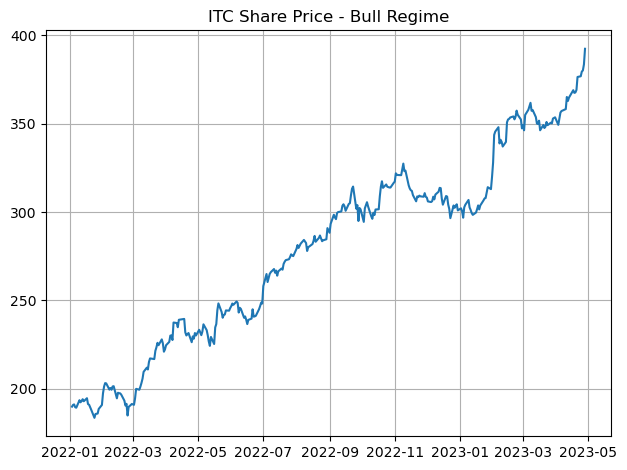

In [89]:
plt.plot(itc['2022-01-01':'2023-05-01'])
plt.title("ITC Share Price - Bull Regime")
plt.grid()
plt.tight_layout()
plt.show()

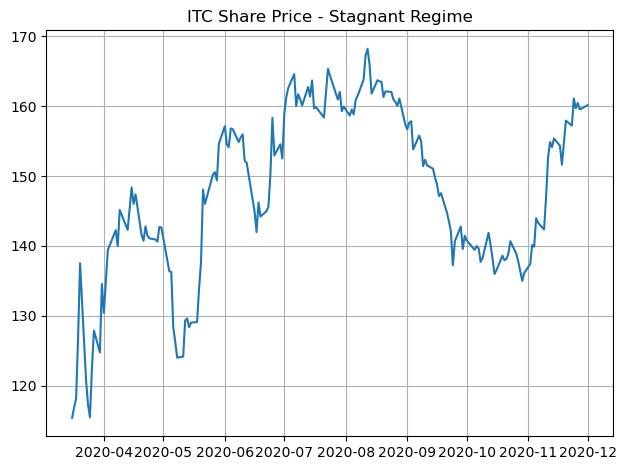

In [109]:
plt.plot(itc['2020-03-15':'2020-12-01'])
plt.title("ITC Share Price - Stagnant Regime")
plt.grid()
plt.tight_layout()
plt.show()

Let is now examine a bear regime

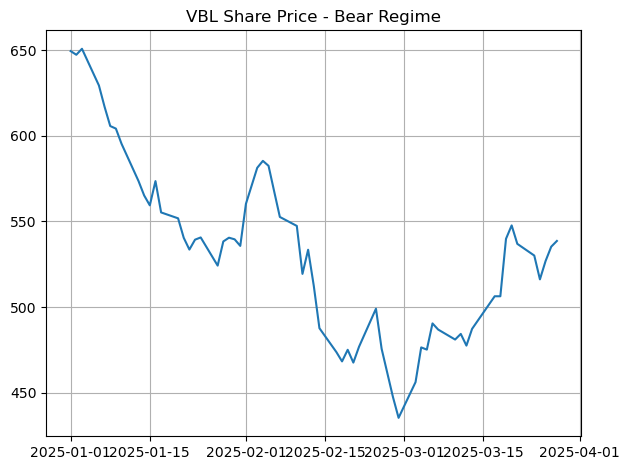

In [113]:
plt.plot(vbl)
plt.title("VBL Share Price - Bear Regime")
plt.grid()
plt.tight_layout()
plt.show()